In [1]:
import cv2
import numpy as np
from skimage import data, io, filters
import scipy
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import OrderedDict
from skimage.measure import  ransac
from itertools import islice

%matplotlib inline

WSET = ['Images/Q2/WorkingSet/I1.jpg','Images/Q2/WorkingSet/I2.jpg','Images/Q2/WorkingSet/I3.jpg']


RuntimeError: module compiled against API version a but this version of numpy is 9

ImportError: numpy.core.multiarray failed to import

In [6]:
imW1 = (io.imread(WSET[0],dtype='float64')/255.0)
imW2 = (io.imread(WSET[1],dtype='float64')/255.0)
imW3 = (io.imread(WSET[2],dtype='float64')/255.0)


### Q1 Viewing

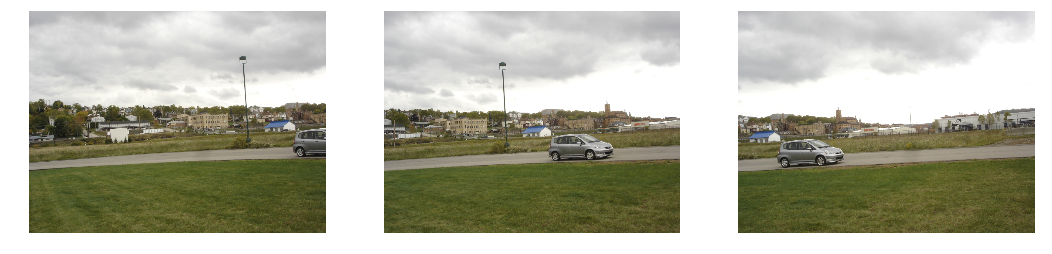

In [7]:
rcParams['figure.figsize'] = 18, 5
fig = plt.figure()
fig, axes = plt.subplots(nrows=1,ncols=3)
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

axes[0].imshow(imW1)
axes[1].imshow(imW2)
axes[2].imshow(imW3)

plt.show()




### Detect Keypoints

In [539]:

sift = cv2.SIFT()

imWgr = []
imW = []
for imName in WSET:
    imWgr.append(cv2.cvtColor(cv2.imread(imName), cv2.COLOR_BGR2GRAY))
    imW.append(cv2.cvtColor(cv2.imread(imName),cv2.COLOR_BGR2RGB))
    
kp=[]
des = []
for im in imWgr:
    kp1,des1 = sift.detectAndCompute(im,None)
    kp.append(kp1)
    des.append(des1)


In [10]:
imgKp1 = cv2.drawKeypoints(imWgr[0],kp[0])
imgKp2 = cv2.drawKeypoints(imWgr[1],kp[1])

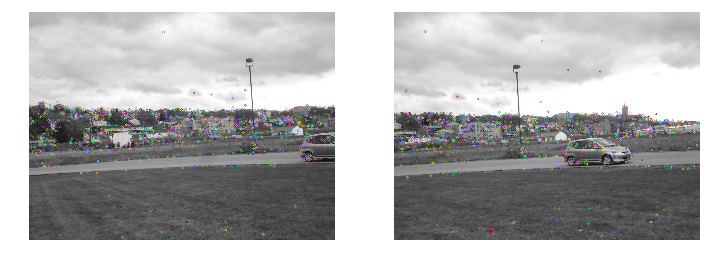

In [11]:
rcParams['figure.figsize'] = 12, 5
fig = plt.figure()
fig, axes = plt.subplots(nrows=1,ncols=2)
axes[0].axis('off')
axes[1].axis('off')

axes[0].imshow(imgKp1,cmap='gray')
axes[1].imshow(imgKp2,cmap='gray')

plt.show()


### Matching keypoints

In [12]:
def bfMatch(kp1,des1,kp2,des2):
    matchDict = {}
    for ipos,i in enumerate(des1):
        minDistPos = -1
        minDist = -1
        #print i
        for pos,j in enumerate(des2):
            dist = np.linalg.norm(i-j)
            if (minDist==-1 or minDist>dist):
                minDist = dist
                minDistPos = pos
        if((pos not in matchDict.keys()) or (matchDict[minDistPos][1]>minDistPos)):
                matchDict[minDistPos] = (ipos,minDist)
    return matchDict
            

In [13]:
matchDict = bfMatch(kp[0],des[0],kp[1],des[1])
matchDict = OrderedDict(sorted(matchDict.items(), key=lambda t: t[1][1]))

orderedKeys = list(islice(matchDict, 50))

In [14]:
imCVW1 = imWgr[0]
imCVW2 = imWgr[1]
kp1 = kp[0]
kp2 = kp[1]

h1, w1 = imCVW1.shape[:2]
h2, w2 = imCVW2.shape[:2]
view = np.zeros((max(h1, h2), w1 + w2, 3), dtype = 'uint8')
view[:h1, :w1, 0] = imCVW1  
view[:h2, w1:, 0] = imCVW2
view[:, :, 1] = view[:, :, 0]  
view[:, :, 2] = view[:, :, 0]

for m in orderedKeys:
    im2x,im2y = kp2[m].pt[0],kp2[m].pt[1]
    #print matchDict[m]
    idxIm1 = matchDict[m][0]
    im1x,im1y = kp1[idxIm1].pt[0],kp1[idxIm1].pt[1]
   
    
    color= tuple([255.0,0.0,0.0])
    cv2.line(view, (int(im1x), int(im1y)) , (int(im2x + w1), int(im2y)), color)


#plt.imshow("view", view)

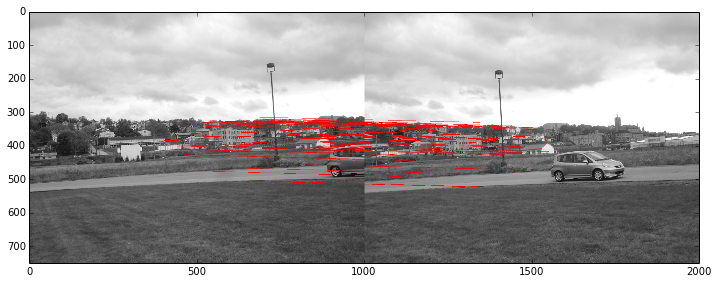

In [15]:
plt.imshow(view)

###  2.5 Finding Homography

In [132]:


##A wrapper function to get homography
def getHomography(kpSrc,kpDst,desSrc,desDst):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desDst,desSrc)
    matches = sorted(matches, key = lambda x:x.distance)


    dst_pts  = np.array([ kpDst[m.queryIdx].pt for m in matches ],dtype=float)
    src_pts = np.array([ kpSrc[m.trainIdx].pt for m in matches ],dtype=float)
    M, mask = cv2.findHomography(src_pts,dst_pts , cv2.RANSAC,4.0)
    return (matches,M,mask)

def getTransMat(H):
    res = np.sum(H,axis=1)
    res = res/res[2]
    Mnew = np.array([[1,0,np.abs(res[0])],[0,1,np.abs(res[1])],[0,0,1]])
    return res,Mnew

In [156]:
matches,M1,mask1 = getHomography(kp[0],kp[1],des[0],des[1])

In [845]:
M1

array([[  1.20619380e+00,  -6.46984763e-03,  -4.09424065e+02],
       [  9.26682343e-02,   1.14207466e+00,  -4.37675172e+01],
       [  2.06550941e-04,   2.88411317e-06,   1.00000000e+00]])

In [157]:
res,Mnew = getTransMat(M1)

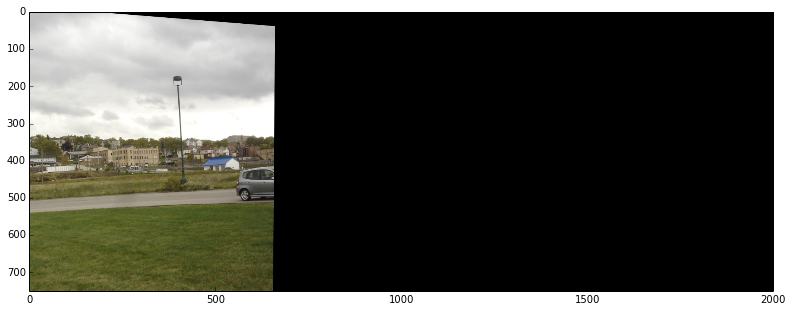

In [846]:
### BEFORE TRANSLATION

imCan = cv2.warpPerspective( imW[0],M1, (imW[0].shape[1]+imW[1].shape[1],imW[1].shape[0]))
plt.imshow(imCan)

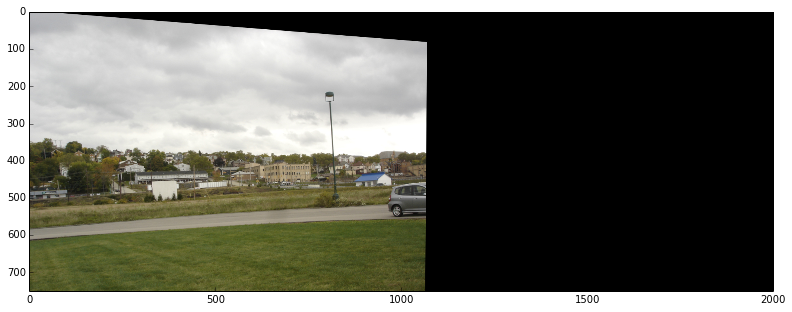

In [856]:
### AFTER TRANSLATION

imCan = cv2.warpPerspective( imW[0],np.dot(Mnew,M1), (imW[0].shape[1]+imW[1].shape[1],imW[1].shape[0]))
plt.imshow(imCan)

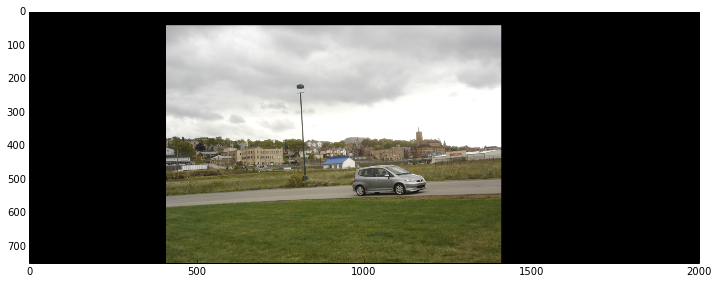

In [159]:
imCan2 = cv2.warpPerspective( imW[1],Mnew, (imW[0].shape[1]+imW[1].shape[1],imW[1].shape[0]))
plt.imshow(imCan2)

###  2.6 Creating a Panaroma

In [853]:
def combine(im1,imDest,mask):
    imz1 = np.float32(np.copy(im1))
    imz2 = np.float32(np.copy(imDest))
    imz1= np.multiply(imz1,mask)
    maskComp = np.ones(mask.shape)
    maskComp = maskComp-mask
    imz2 =np.multiply(imz2,maskComp)
    return cv2.add(imz1,imz2)


In [1081]:
mask = np.ones((h,w,3))
mask[int(np.abs(res[1])):,int(np.abs(res[0])):,:]=0
resx = combine(imCan,imCan2,mask)

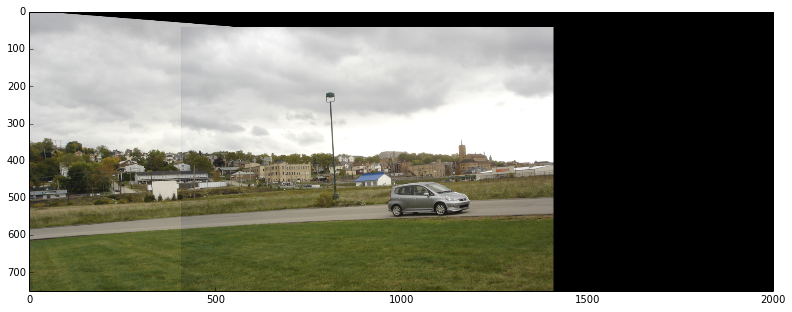

In [1082]:
plt.imshow(resx/255.0)

### 2.7 Stitching lines

In [1074]:
def combineMultiMasks(im1,imDest,mask1,mask2):
    imz1 = np.float32(np.copy(im1))
    imz2 = np.float32(np.copy(imDest))
    imz1= np.multiply(imz1,mask1)
    imz2 =np.multiply(imz2,mask2)
    return cv2.add(imz1,imz2)

def getGaussianPyramids(img,level):
    G = img
    gp = [G]
    for i in xrange(level):
        G = cv2.pyrDown(G)
        gp.append(G)
    return (gp)


def getLaplacianPyramids(img, level, gp):
    # generate Laplacian Pyramid for A
    lp = [gp[level-1]]
    for i in xrange(level-1,0,-1):
        GE = cv2.pyrUp(gp[i])
        h,w,_ = gp[i-1].shape
        GEnew = GE[0:h,0:w,:]
        L = cv2.subtract(gp[i-1],GEnew)
        lp.append(L)
    return lp    

def getMasks(im1, im2):
    mask1 =np.float64(np.copy(im1))
    mask1[np.where(im1>0)] = 1.0
    mask1[np.where(im1<0)] = 0.0

    mask2 = np.float64(np.copy(im2))
    mask2[np.where(im2>0)] = 1.0
    mask2[np.where(im2<0)] = 0.0
    
    mask1[np.where((mask1+mask2)==2.0)] = 0.0
    
    h,w,_ = im1.shape
    for i in xrange(h):
        for j in xrange(w-1):
            if((mask1[i,j]==np.ones(3)).all() and (mask1[i,j+1]==np.zeros(3)).all()):
                for x in range(1,20):
                    mask1[i,j+x] = np.array([1,1,1])*(0.1*(10-(x/2)))
                    mask2[i,j+x] = np.array([1,1,1])*(0.1*(x/2))
                break
    return mask1,mask2

def pyramidBlend(imCan,imCan2,levels):
    imCan = np.float32(imCan)
    mask1,mask2 = getMasks(imCan,imCan2)
    gpIm1 = getGaussianPyramids(imCan,levels)
    lpIm1 = getLaplacianPyramids(imCan, levels, gpIm1)
    gpIm2 = getGaussianPyramids(imCan2,levels)
    lpIm2 = getLaplacianPyramids(imCan2, levels, gpIm2)
    gpMask1= getGaussianPyramids(mask1,levels)
    gpMask2= getGaussianPyramids(mask2,levels)


    LS = []
    count = levels-1
    for la,lb in zip(lpIm1,lpIm2):
        lb = combineMultiMasks(la,lb,gpMask1[count],gpMask2[count])
        LS.append(lb)
        count -=1

    # now reconstruct
    resp = LS[0]
    for i in xrange(1,levels):
        resp = cv2.pyrUp(resp)
        h,w,_ = LS[i].shape
        resp = resp[0:h,0:w,:]
        resp = cv2.add(resp, LS[i])

    resp[np.where(resp<0)]=0
    resp[np.where(resp>255)] = 255.0

    return resp,LS,lpIm1,lpIm2
  
    

In [1075]:
resp,LS,lpIm1,lpIm2= pyramidBlend(imCan,imCan2,3)

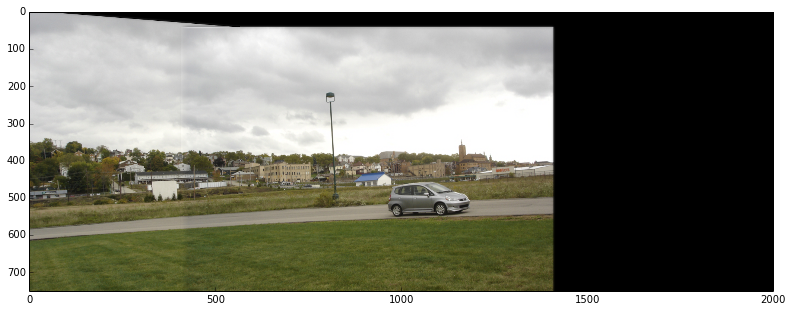

In [1076]:
plt.imshow(resp/255.0)

### 2.8 Complete Panoroma 

In [374]:
matches2,M2,_ = getHomography(kp[2],kp[1],des[2],des[1])
res2,Mnew2 = getTransMat(M2)
imCan3 = np.float64(cv2.warpPerspective( imW[2],np.dot(Mnew,M2), (imW[0].shape[1]+imW[1].shape[1],imW[1].shape[0])))


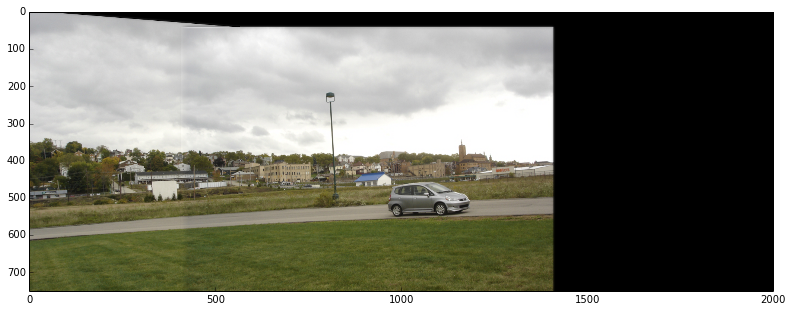

In [1077]:
plt.imshow(resp/255.0)

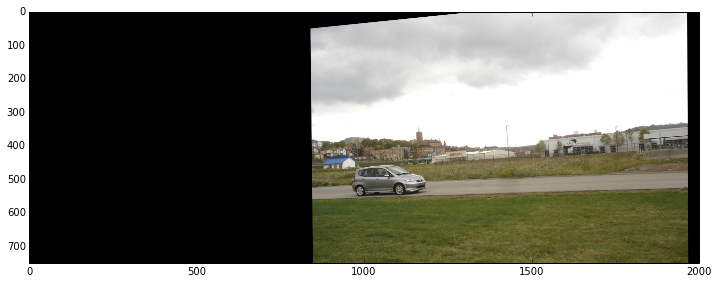

In [466]:
plt.imshow(imCan3/255.0)

In [1079]:
mask3 = np.ones(mask.shape)
mask3[:,:-int(resf[0]),:] = 0
resf = np.abs(res)+res2
resx = combine(imCan3,resp,mask3)

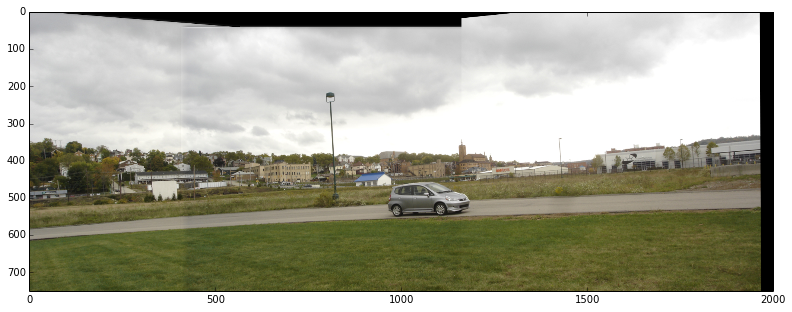

In [1080]:
plt.imshow(resx/255.0)

### 2.9 Generalizing II

In [519]:
#load images
imS1 = []
imS1gr = []

for i in [1,2,3]:
    imName = 'Images/Q2/OtherSets/Normal set/M'+str(i)+'.jpg'
    imS1gr.append(cv2.cvtColor(cv2.imread(imName), cv2.COLOR_BGR2GRAY))
    imS1.append(cv2.cvtColor(cv2.imread(imName),cv2.COLOR_BGR2RGB))

## detect keypoints    
kpS1=[]
desS1 = []
for im in imS1gr:
    kp1,des1 = sift.detectAndCompute(im,None)
    kpS1.append(kp1)
    desS1.append(des1)



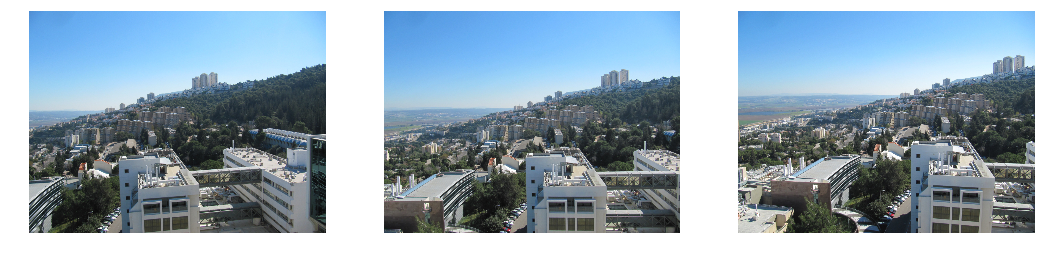

In [500]:
rcParams['figure.figsize'] = 18, 5
fig = plt.figure()
fig, axes = plt.subplots(nrows=1,ncols=3)
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

axes[0].imshow(imS1[0])
axes[1].imshow(imS1[1])
axes[2].imshow(imS1[2])

plt.show()





The algorithm implemented to obtain a full panorama is as follows:
1. Keypoints and descriptors are calculated for all images

2. Matches are found between all unique image pairs (i,j)

3. The dictionary of matches is sorted in descending order, and one of the images belonging to the topmost pair (pair with maximum matches) is chosen as the reference image. The H matrix of this image is an identity matrix I. H_ji  is the homography matrix of image j (assuming image i was chosen as the reference image). Note: the homography matrices are stored in the order of addition required for panorama image creation.

4. The dictionary is iterated over until homography of all images haven’t been calculated. Let’s say (x,y) is the next key in the (sorted) dictionary and let the current H list be [(x,M1),…….,(a,M2)]. In this case the transform of image y w.r.t x, this transform is multiplied to M1 and appended to the front of list H to give [(y,Mnew),(x,M1),……(a,M2)]. After this step, all keys containing x are removed from the dictionary. (Similar handling is done for the rest of the three cases )

5. After Homography matrices are calculated as per the previous step, translation matrix is obtained by calculating the max left translation caused by the homographies. This translation matrix is multiplied to all homographies and the transformed images are obtained for each of the images. 

6. After applying an appropriate mask for each image, these transformed images are added to obtain the final image.


In [1090]:
def getCanvasShape(imList):
    hf = 0
    wf = 0
    for im in imList:
        h,w,_ = im.shape
        hf = h if h>hf else hf
        wf += w
    return (hf,wf,3)

def getHomography(matches,kpSrc,kpDst,inv=False):
    dst_pts = []
    stc_pts = []
    if(inv==False):
        dst_pts  = np.array([ kpDst[m.queryIdx].pt for m in matches ],dtype=float)
        src_pts = np.array([ kpSrc[m.trainIdx].pt for m in matches ],dtype=float)
    else:
        dst_pts  = np.array([ kpDst[m.trainIdx].pt for m in matches ],dtype=float)
        src_pts = np.array([ kpSrc[m.queryIdx].pt for m in matches ],dtype=float) 
    
    M, mask = cv2.findHomography(src_pts,dst_pts , cv2.RANSAC,15.0)
    
    return M,mask

def removeTuples(matchDict,i):
    for (a,b) in list(matchDict.keys()):
        if(a==i or b==i):
            del matchDict[(a,b)]
    
##Calculates matches between all pairs of images
def getAllMatches(kpList,desList):
    matchesDict = {}
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    
    for i in range(len(kpList)):
        for j in range(i,len(kpList)):
            if(i==j):
                continue
            matches = bf.match(desList[j],desList[i])
            matches = sorted(matches, key = lambda x:x.distance)          
            matchesDict[(i,j)] = matches 
    
    matchesDict = OrderedDict(sorted(matchesDict.items(), key=lambda t: len(t[1]),reverse = True))
    return matchesDict

#Calculates homographies for all the images required for warpPerspective    
def createHomographiesForPanorama(mDict,imCount,kpList):
    H = []
    count = 0
    matchesDict = mDict.copy()
    while(count<imCount ):
        for (i,j) in matchesDict.keys():
            if(count==imCount):
                break
            if(not matchesDict.has_key((i,j))):
                continue
                
            matches = matchesDict[(i,j)]
            if(H==[]):
                M,_ = getHomography(matches,kpList[i],kpList[j])
                H.append((i,M))
                H.append((j,np.eye(3)))
                del matchesDict[(i,j)]
                count+=2
            else:
                (a,Ma) = H[0]
                (b,Mb) = H[-1]
                if((i==a and j==b) or (i==b and j==a)):
                    del matchesDict[(i,j)]
                    continue
                if(i==a):
                    M,_ = getHomography(matches,kpList[j],kpList[i],inv=True)
                    H.insert(0,(j,np.dot(M,Ma)))
                    removeTuples(matchesDict,i)
                    count +=1


                elif(i==b):
                    M,_ = getHomography(matches,kpList[j],kpList[i],inv=True)
                    H.append((j,np.dot(M,Mb)))
                    removeTuples(matchesDict,i)
                    count +=1

                elif(j==a):
                    M,_ = getHomography(matches,kpList[i],kpList[j])
                    H.insert(0,(i,np.dot(M,Ma)))
                    removeTuples(matchesDict,j)
                    count +=1

                elif(j==b):
                    M,_ = getHomography(matches,kpList[i],kpList[j])
                    H.append((i,np.dot(M,Mb)))
                    removeTuples(matchesDict,j)
                    count +=1
    return H

def findTransMat(H):
    x_offset = 0
    y_offset = 0
    for i,M in H:
        res = np.sum(M,axis=1)
        res = res/res[2]
        x_offset = min(x_offset,res[0])
        y_offset = min(y_offset,res[1])
    
    if(x_offset>=0 and y_offset<0):
        y_offset = 0
    Mnew = np.array([[1,0,np.abs(x_offset)],[0,1,np.abs(y_offset)],[0,0,1]])
    return Mnew

def createPanorama(imList,H):
    imwarp = []
    ch,cw,_ = getCanvasShape(imList)
    trans = findTransMat(H)
    
    for i,M in H:
        imwarp.append(cv2.warpPerspective( imList[i],np.dot(trans,M), (cw,ch)))

    imFinal = np.zeros((ch,cw,3),dtype=np.uint8)

    for im in imwarp:
        imFinal = combine(im,imFinal)
    return imFinal
            

def combine(im1, im2):
    mask1 = np.copy(im1)
    mask1[np.where(im1>0)] = 1
    mask1[np.where(im1<0)] = 0

    mask2 = np.copy(im2)
    mask2[np.where(im2>0)] = 1
    mask2[np.where(im2<0)] = 0
    im1[np.where(mask1+mask2==2)] = 0

    return cv2.add(im1,im2)


In [767]:
mDict = getAllMatches(kpS1,desS1)
H= createHomographiesForPanorama(mDict,len(imS1),kpS1)

In [1091]:
imFinal = createPanorama(imS1,H)

In [716]:
ch,cw,_ = getCanvasShape(imS1)


In [754]:
imS10wp = cv2.warpPerspective( imS1[H[0][0]],H[0][1], (cw,ch))

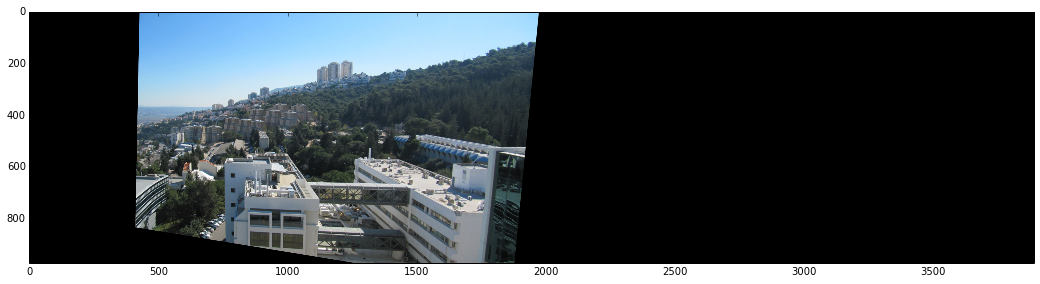

In [755]:
plt.imshow(imS10wp)

In [756]:
imS11wp = cv2.warpPerspective( imS1[H[1][0]],H[1][1], (cw,ch))

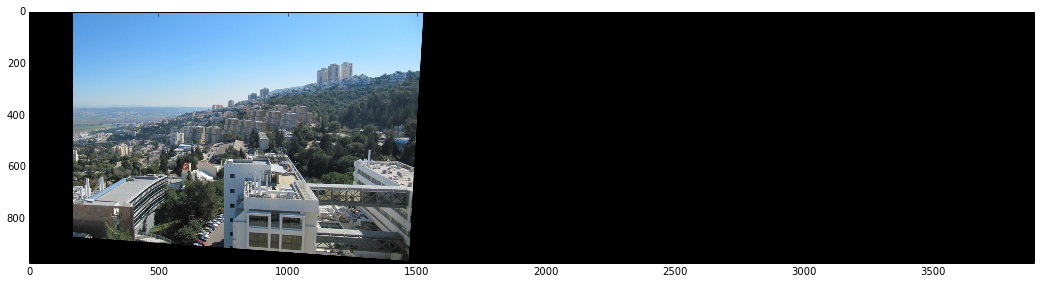

In [757]:
plt.imshow(imS11wp)

In [758]:
imS12wp = cv2.warpPerspective( imS1[H[2][0]],H[2][1], (cw,ch))

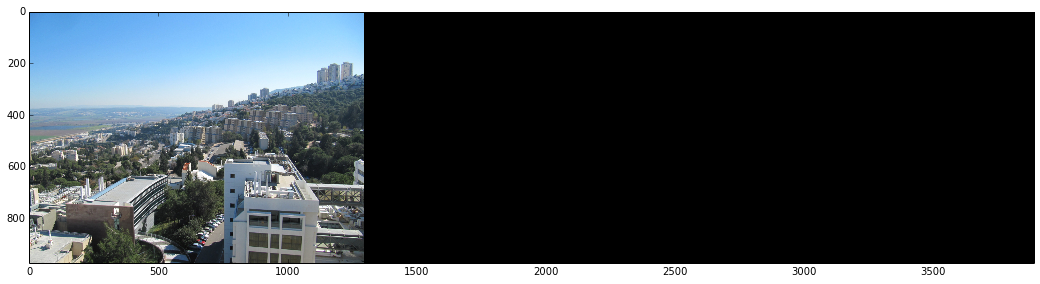

In [759]:
plt.imshow(imS12wp)

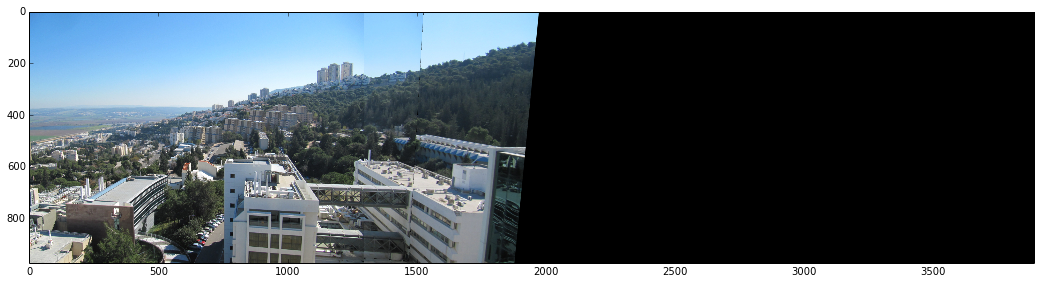

In [760]:
plt.imshow(combine(combine(imS10wp,imS11wp),imS12wp))

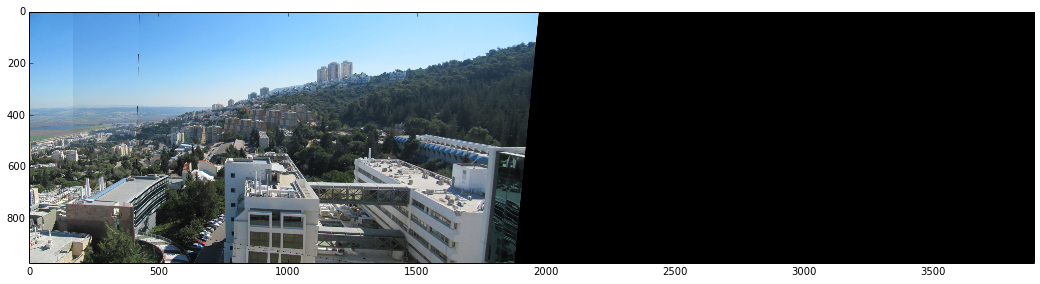

In [841]:
plt.imshow(imFinal)

In [696]:
#load images
imS2 = []
imS2gr = []

for i in range(1,10):
    imName = 'Images/Q2/OtherSets/Technion set/T'+str(i)+'.jpg'
    imS2gr.append(cv2.cvtColor(cv2.imread(imName), cv2.COLOR_BGR2GRAY))
    imS2.append(cv2.cvtColor(cv2.imread(imName),cv2.COLOR_BGR2RGB))

## detect keypoints    
kpS2=[]
desS2 = []
for im in imS2gr:
    kp1,des1 = sift.detectAndCompute(im,None)
    kpS2.append(kp1)
    desS2.append(des1)




In [736]:
matchesDict = getAllMatches(kpS2,desS2)

In [750]:
H2= createHomographiesForPanorama(matchesDict,len(imS2),kpS2)

In [842]:
imFinalTechnion = createPanorama(imS2,H2)
imFinalTechnion = imFinalTechnion[:,:6000,:]

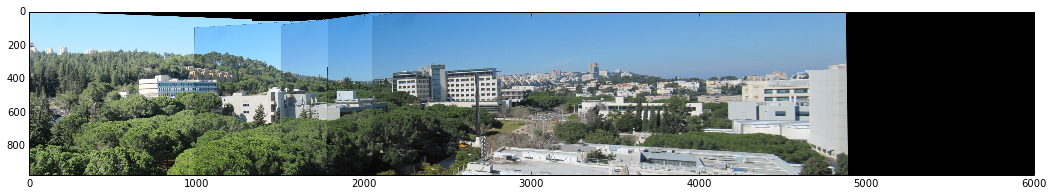

In [843]:
plt.imshow(imFinalTechnion)

In [ ]:
[[1,0,x_offset],[0,1,y_offset],[0,0,1]]

In [1053]:
np.array([1,1,1])*0.7

array([ 0.7,  0.7,  0.7])